In [152]:
import keras
from keras.layers import Conv1D, Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization
from keras.layers import Dropout, Input
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils

from scipy.io import loadmat
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

from operator import truediv

from plotly.offline import init_notebook_mode

import pandas as pd
import numpy as np
!pip install spectral
import spectral
import matplotlib.pyplot as plt
init_notebook_mode(connected=True)
%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [153]:
def read_HSI():
  X = loadmat('Indian_pines_corrected.mat')['indian_pines_corrected']
  y = loadmat('Indian_pines_gt.mat')['indian_pines_gt']
  print(f"X shape: {X.shape}\ny shape: {y.shape}")
  return X, y


In [154]:
def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0], X.shape[1], numComponents))
    return newX, pca

In [155]:
def padWithZeros(X, margin=2):
    newX = np.zeros(
        (X.shape[0] + 2 * margin, X.shape[1] + 2 * margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX


In [156]:
def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels


In [157]:
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

In [158]:
def Patch(data, height_index, width_index):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]

    return patch

In [159]:
test_ratio = 0.7
windowSize = 25

# INDIAN PINES **HybridSN**

In [160]:
X, y = read_HSI()

X shape: (145, 145, 200)
y shape: (145, 145)


In [161]:
K=30

In [162]:
X, pca = applyPCA(X, numComponents=K)

X.shape


(145, 145, 30)

In [163]:
print(X.shape)
print(y.shape)

(145, 145, 30)
(145, 145)


In [164]:
X, y = createImageCubes(X, y, windowSize=windowSize)

X.shape, y.shape

((10249, 25, 25, 30), (10249,))

In [165]:
def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test


In [166]:
y

array([2., 2., 2., ..., 9., 9., 9.])

In [167]:
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X, y, test_ratio)
print(Xtrain.shape)
print(Xtest.shape)
print(ytrain.shape)
print(ytest.shape)

(3074, 25, 25, 30)
(7175, 25, 25, 30)
(3074,)
(7175,)


In [168]:
ytrain = np_utils.to_categorical(ytrain)
ytrain.shape

(3074, 16)

In [169]:
Xtrain = Xtrain.reshape(-1, windowSize, windowSize, K, 1)
Xtrain.shape

(3074, 25, 25, 30, 1)

In [170]:

S = windowSize
L = K
output_units =16

In [171]:
## input layer
input_layer = Input((S, S, L, 1))

## convolutional layers
conv_layer1 = Conv3D(filters=8, kernel_size=(
    3, 3, 7), activation='relu')(input_layer)
conv_layer2 = Conv3D(filters=16, kernel_size=(
    3, 3, 5), activation='relu')(conv_layer1)
conv_layer3 = Conv3D(filters=32, kernel_size=(
    3, 3, 3), activation='relu')(conv_layer2)
print(conv_layer3.shape)
conv3d_shape = conv_layer3.shape
conv_layer3 = Reshape((conv3d_shape[1], conv3d_shape[2], conv3d_shape[3]*conv3d_shape[4]))(conv_layer3)
print(conv_layer3)
conv_layer4 = Conv2D(filters=64, kernel_size=(3,3), activation='relu')(conv_layer3)

flatten_layer = Flatten()(conv_layer4)

print(conv_layer4.shape, flatten_layer.shape)

## fully connected layers
dense_layer1 = Dense(units=256, activation='relu')(flatten_layer)
dense_layer1 = Dropout(0.4)(dense_layer1)
dense_layer2 = Dense(units=128, activation='relu')(dense_layer1)
dense_layer2 = Dropout(0.4)(dense_layer2)
output_layer = Dense(units=output_units, activation='softmax')(dense_layer2)



(None, 19, 19, 18, 32)
KerasTensor(type_spec=TensorSpec(shape=(None, 19, 19, 576), dtype=tf.float32, name=None), name='reshape_5/Reshape:0', description="created by layer 'reshape_5'")
(None, 17, 17, 64) (None, 18496)


In [172]:
model = Model(inputs=input_layer, outputs=output_layer)

In [173]:
model.summary()


Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 25, 25, 30, 1)]   0         
                                                                 
 conv3d_15 (Conv3D)          (None, 23, 23, 24, 8)     512       
                                                                 
 conv3d_16 (Conv3D)          (None, 21, 21, 20, 16)    5776      
                                                                 
 conv3d_17 (Conv3D)          (None, 19, 19, 18, 32)    13856     
                                                                 
 reshape_5 (Reshape)         (None, 19, 19, 576)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 17, 17, 64)        331840    
                                                                 
 flatten_5 (Flatten)         (None, 18496)             0   

In [174]:
adam = Adam(lr=0.001, decay=1e-06)
model.compile(loss='categorical_crossentropy',
              optimizer=adam, metrics=['accuracy'])

/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



In [175]:
filepath = "./best_model_hybridSN.hdf5"
checkpoint = ModelCheckpoint(
    filepath, monitor='acc', verbose=1, save_weights_only=True, mode='max')
callbacks_list = [checkpoint]

In [176]:
history = model.fit(x=Xtrain, y=ytrain, batch_size=256,
                    epochs=25, callbacks=callbacks_list)

Epoch 1/25
12/13 [==========================>...] - ETA: 0s - loss: 2.5172 - accuracy: 0.2119
Epoch 1: saving model to ./best_model_hybridSN.hdf5
13/13 [==============================] - 3s 198ms/step - loss: 2.5159 - accuracy: 0.2124
Epoch 2/25
12/13 [==========================>...] - ETA: 0s - loss: 2.0004 - accuracy: 0.3678
Epoch 2: saving model to ./best_model_hybridSN.hdf5
13/13 [==============================] - 3s 197ms/step - loss: 2.0026 - accuracy: 0.3676
Epoch 3/25
12/13 [==========================>...] - ETA: 0s - loss: 1.4104 - accuracy: 0.5540
Epoch 3: saving model to ./best_model_hybridSN.hdf5
13/13 [==============================] - 3s 201ms/step - loss: 1.4095 - accuracy: 0.5543
Epoch 4/25
12/13 [==========================>...] - ETA: 0s - loss: 0.8658 - accuracy: 0.7350
Epoch 4: saving model to ./best_model_hybridSN.hdf5
13/13 [==============================] - 3s 203ms/step - loss: 0.8653 - accuracy: 0.7352
Epoch 5/25
12/13 [==========================>...] - ETA: 0s 

In [177]:
model.load_weights("./best_model_hybridSN.hdf5")

model.compile(loss='categorical_crossentropy',
              optimizer=adam, metrics=['accuracy'])

In [178]:
Xtest = Xtest.reshape(-1, windowSize, windowSize, K, 1)
Xtest.shape

(7175, 25, 25, 30, 1)

In [179]:
ytest = np_utils.to_categorical(ytest)
ytest.shape

(7175, 16)

In [180]:
Y_pred_test = model.predict(Xtest)
y_pred_test = np.argmax(Y_pred_test, axis=1)

classification = classification_report(np.argmax(ytest, axis=1), y_pred_test)
print(classification)


225/225 [==============================] - 2s 10ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        32
           1       1.00      1.00      1.00      1000
           2       1.00      0.99      0.99       581
           3       0.99      1.00      1.00       166
           4       1.00      1.00      1.00       338
           5       1.00      1.00      1.00       511
           6       1.00      1.00      1.00        20
           7       1.00      1.00      1.00       335
           8       0.76      0.93      0.84        14
           9       1.00      0.99      0.99       680
          10       0.99      1.00      1.00      1719
          11       0.98      1.00      0.99       415
          12       1.00      1.00      1.00       143
          13       1.00      1.00      1.00       886
          14       1.00      1.00      1.00       270
          15       1.00      0.88      0.93        65

    accuracy            

In [181]:
def reports(X_test, y_test):
    #start = time.time()
    Y_pred = model.predict(X_test)
    y_pred = np.argmax(Y_pred, axis=1)
    #end = time.time()
    #print(end - start)

    target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn', 'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed',
                    'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                    'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
                    'Stone-Steel-Towers']

    classification = classification_report(
        np.argmax(y_test, axis=1), y_pred, target_names=target_names)
    oa = accuracy_score(np.argmax(y_test, axis=1), y_pred)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)
    score = model.evaluate(X_test, y_test, batch_size=32)
    Test_Loss = score[0]*100
    Test_accuracy = score[1]*100

    return classification, confusion, Test_Loss, Test_accuracy, oa*100, each_acc*100, aa*100, kappa*100

In [182]:
classification, confusion, Test_loss, Test_accuracy, oa, each_acc, aa, kappa = reports(Xtest,ytest)

225/225 [==============================] - 3s 12ms/step - loss: 0.0105 - accuracy: 0.9958


In [183]:
classification = str(classification)
confusion = str(confusion)
print(classification)
print(confusion)


                              precision    recall  f1-score   support

                     Alfalfa       1.00      1.00      1.00        32
                 Corn-notill       1.00      1.00      1.00      1000
                Corn-mintill       1.00      0.99      0.99       581
                        Corn       0.99      1.00      1.00       166
               Grass-pasture       1.00      1.00      1.00       338
                 Grass-trees       1.00      1.00      1.00       511
         Grass-pasture-mowed       1.00      1.00      1.00        20
               Hay-windrowed       1.00      1.00      1.00       335
                        Oats       0.76      0.93      0.84        14
              Soybean-notill       1.00      0.99      0.99       680
             Soybean-mintill       0.99      1.00      1.00      1719
               Soybean-clean       0.98      1.00      0.99       415
                       Wheat       1.00      1.00      1.00       143
                   

In [184]:
file_name = "classification_report_hybridSN.txt"

In [185]:
with open(file_name, 'w') as x_file:
    x_file.write('{} Test loss (%)'.format(Test_loss))
    x_file.write('\n')
    x_file.write('{} Test accuracy (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{} Kappa accuracy (%)'.format(kappa))
    x_file.write('\n')
    x_file.write('{} Overall accuracy (%)'.format(oa))
    x_file.write('\n')
    x_file.write('{} Average accuracy (%)'.format(aa))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write('{}'.format(confusion))

In [186]:
X, y = read_HSI()

X shape: (145, 145, 200)
y shape: (145, 145)


In [187]:
height = y.shape[0]
width = y.shape[1]
PATCH_SIZE = windowSize
numComponents = K

In [188]:
X,pca = applyPCA(X, numComponents=numComponents)

In [189]:
X = padWithZeros(X, PATCH_SIZE//2)

In [190]:
# calculate the predicted image
outputs = np.zeros((height, width))
for i in range(height):
    for j in range(width):
        target = int(y[i, j])
        if target == 0:
            continue
        else:
            image_patch = Patch(X, i, j)
            X_test_image = image_patch.reshape(
                1, image_patch.shape[0], image_patch.shape[1], image_patch.shape[2], 1).astype('float32')
            prediction = (model.predict(X_test_image))
            prediction = np.argmax(prediction, axis=1)
            outputs[i][j] = prediction+1


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 69ms/step


/usr/local/lib/python3.9/dist-packages/spectral/graphics/spypylab.py:796: UserWarning:

Failed to create RectangleSelector object. Interactive pixel class labeling will be unavailable.



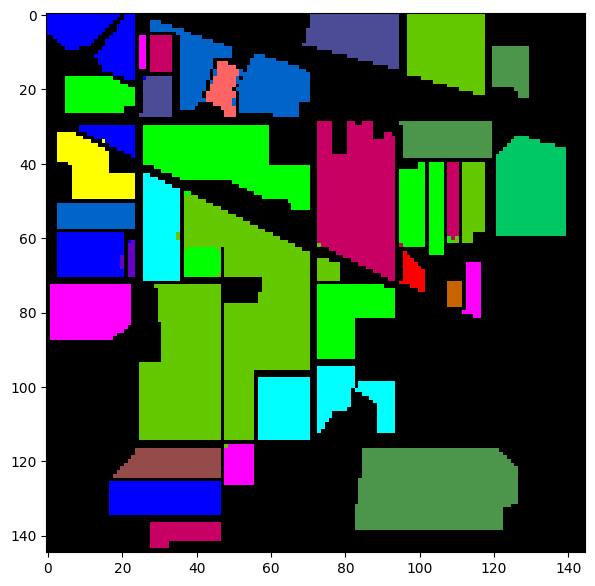

In [191]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(7,7))

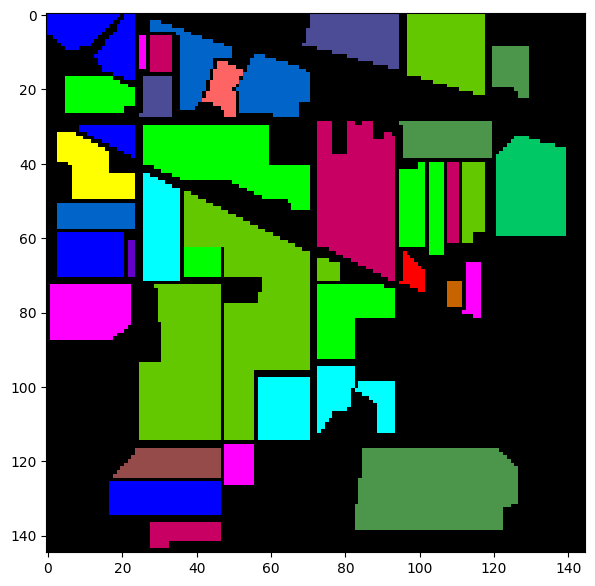

In [192]:
ground_truth = spectral.imshow(classes = y,figsize =(7,7))